# Quantitative strategy case interview for Dr. Li Zhihuan
## Section 2

Firstly, the relevant datasets were downloaded from [Data.gov.sg resale flat prices](https://beta.data.gov.sg/datasets?query=resale%20flat%20prices). Although the question suggested that I download 4 datasets, up to Jan 2015 - Dec 2016, I found an additional dataset covering resale flat prices from Jan 2017. For the sake of completeness, the additional dataset was downloaded and included in this analysis. 

In [2]:
import pandas as pd 
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

The datasets should firstly be imported into Pandas dataframes and preprocessed. 

While perusing the data.gov.sg website to get an idea of the datasets I need, as well as the column legend, I realised that the schema of the datasets changed over the years. Thus, the datasets will have to be cleaned after merging. Of particular note is the 'remaining lease' column, which does not appear in datasets before Jan 2015. The 'remaining lease' column of Jan 2015 - Dec 2016 and Jan 2107 onwards also have different granularity *(Years remaining and years and months remaining respectively)*.

The relevant datasets may be called by the official data.gov.sg API or manually downloaded. Downloading the datasets manually may be faster but as I would need to send this Jupyter notebook file to others, it is cleaner to call the datasets with the API.

The official data.gov.sg API is undergoing a revamp at the time of this analysis and it was recommended that the datasets be called with the older version of the API. Please contact me if the API stops working. 

***(API to be supported beyond 15 Nov 23, last checked on 23 Nov 23)***

I will build a basic dataframe, before doing processing and splitting the dataframe in different copies to answer the different questions.

In [3]:
# The datasets to be called are first input into a list.
json_call=[
    'https://data.gov.sg/api/action/datastore_search?resource_id=d_8b84c4ee58e3cfc0ece0d773c8ca6abc',
    'https://data.gov.sg/api/action/datastore_search?resource_id=d_ea9ed51da2787afaf8e51f827c304208',
    'https://data.gov.sg/api/action/datastore_search?resource_id=d_2d5ff9ea31397b66239f245f57751537',
    'https://data.gov.sg/api/action/datastore_search?resource_id=d_43f493c6c50d54243cc1eab0df142d6a',
    'https://data.gov.sg/api/action/datastore_search?resource_id=d_ebc5ab87086db484f88045b47411ebc5'
]

# Next, the datasets will be called in JSON format and combined into a dataframe

def access_api(json_call):
    hdb_records=[]
    
    for url in json_call:
        offset = 0
        limit = 10000

        while True:
            url_with_offset = f"{url}&offset={offset}&limit={limit}"
            response = requests.get(url_with_offset)
            data = response.json()

            records = data['result']['records']
            hdb_records.extend(records)

            if len(records) < limit:
                break

            offset += limit
        
    return hdb_records

In [4]:
def build_df(hdb_records):
    finaldf=[]
                    
    # We will feed the JSON response into lists and then map them into a dataframe. 
    _id = []
    month = []
    town = []
    flat_type = []
    block = []
    street_name = []
    storey_range = []
    floor_area_sqm = []  
    flat_model = []
    lease_commence_date = []
    resale_price = []
        
    # Values are only mapped into the 'remaining_lease' list if it is the newer datasets (i.e. latest two datasets)
    for i in range(len(hdb_records)):
        _id.append(hdb_records[i]['_id'])
        month.append(hdb_records[i]['month'])
        town.append(hdb_records[i]['town'])
        flat_type.append(hdb_records[i]['flat_type'])
        block.append(hdb_records[i]['block'])
        street_name.append(hdb_records[i]['street_name'])
        storey_range.append(hdb_records[i]['storey_range'])
        floor_area_sqm.append(hdb_records[i]['floor_area_sqm'])
        flat_model.append(hdb_records[i]['flat_model'])
        lease_commence_date.append(hdb_records[i]['lease_commence_date'])
        resale_price.append(hdb_records[i]['resale_price'])

    # Append finaldf to be combined later
    
    finaldf.append(pd.DataFrame
    ({
        '_id': _id,
        'month': month,
        'town': town,
        'flat_type': flat_type,
        'block': block,
        'street_name': street_name,
        'storey_range': storey_range,
        'floor_area_sqm': floor_area_sqm,
        'flat_model': flat_model,
        'lease_commence_date': lease_commence_date,
        'resale_price': resale_price,
    }))
    
    return pd.concat(finaldf,ignore_index=True)

In [5]:
hdb_records=access_api(json_call)

In [6]:
# Dataframe of HDB resale records built
df=build_df(hdb_records)

# Exporting to CSV for use in section 1 and 3
# df.to_csv('hdb_df.csv', index=False)

We shall now take a look at the dataframe that we have built to ensure that all rows have been imported correctly.

In [7]:
df.sample(5)

,_id,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
736863,110393,1995-12,KALLANG/WHAMPOA,3 ROOM,32,JLN BAHAGIA,01 TO 03,56,STANDARD,1971,100000
12096,12097,2017-08,GEYLANG,3 ROOM,67,CIRCUIT RD,04 TO 06,61,Standard,1969,215000
8852,8853,2017-06,KALLANG/WHAMPOA,3 ROOM,86,WHAMPOA DR,04 TO 06,66,Improved,1974,283000
417966,161147,2004-10,PASIR RIS,4 ROOM,573,PASIR RIS ST 53,01 TO 03,112,Model A,1995,318000
113912,113913,2021-11,TOA PAYOH,5 ROOM,153,LOR 2 TOA PAYOH,28 TO 30,124,Improved,1999,1065000


In [8]:
df.describe(include='all')

,_id,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
count,913667.000000,913667,913667,913667,913667,913667,913667,913667,913667,913667,913667
unique,NaN,408,27,8,2696,584,25,210,34,56,9332
top,NaN,1999-03,TAMPINES,4 ROOM,2,YISHUN RING RD,04 TO 06,67,Model A,1985,300000
freq,NaN,6465,79034,346555,4558,17432,229480,68518,189355,86701,6881
mean,137508.527613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,99726.049510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,47816.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,122493.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,214215.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# The datatype of the various columns need to be changed
df.dtypes

_id                     int64
month                  object
town                   object
flat_type              object
block                  object
street_name            object
storey_range           object
floor_area_sqm         object
flat_model             object
lease_commence_date    object
resale_price           object
dtype: object

In [11]:
df['lease_commence_date'] = df['lease_commence_date'].astype(int)
df['resale_price'] = df['resale_price'].astype(float)
df['floor_area_sqm'] = df['floor_area_sqm'].astype(float)

<function matplotlib.pyplot.show(close=None, block=None)>

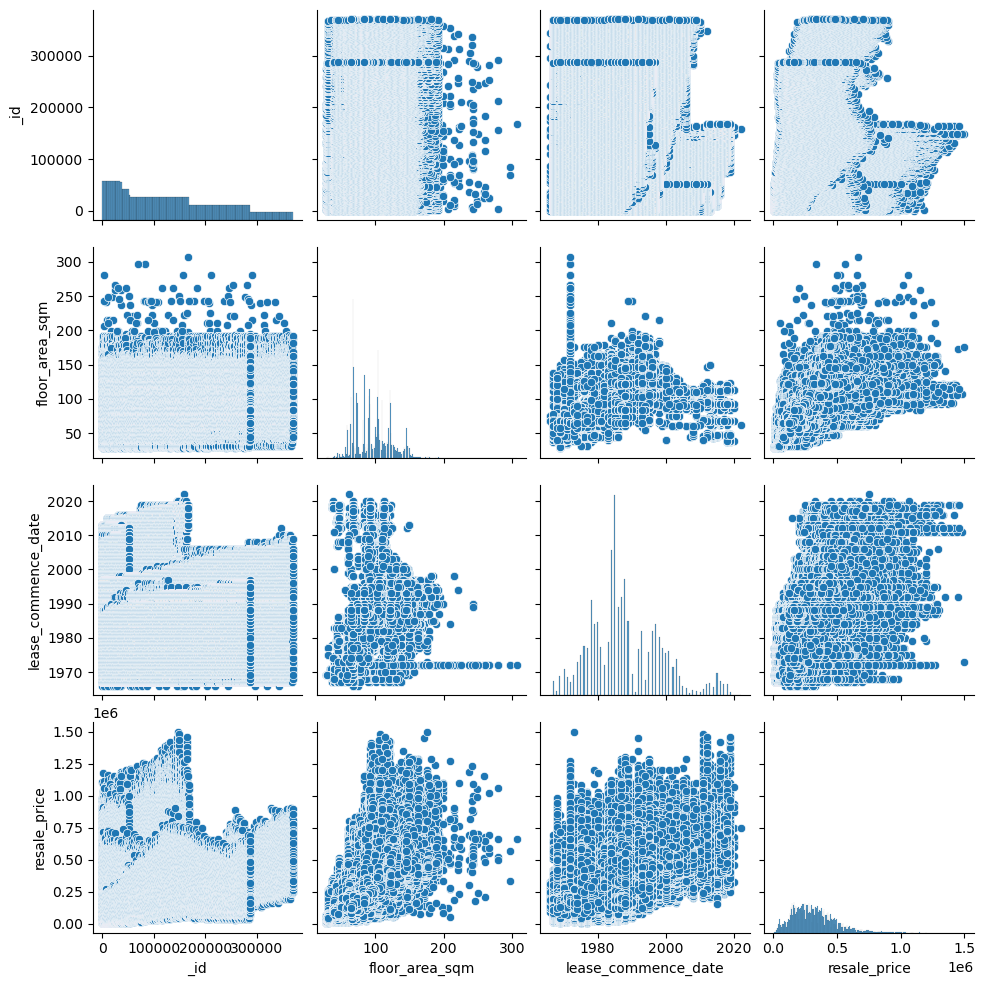

In [12]:
sns.pairplot(df)
plt.show

A quick check reveals no obvious errors

# Section 2
## Question A
Predict a resale flat price’s transaction price in 2014. Use the following characteristics:
**flat type, flat age and town**. Propose and implement a **minimum of three models**, select the best
model, and explain the reasons for your choice.

We would need to clean the dataset. This is done by splitting the dataframe into another copy and processing it. In case any mistakes were made, the base dataframe will not be affected.

For the flat age feature, this will be calculated from the transaction date and the lease_commencement_date, as this data is not present in earlier datasets.

In [13]:
# Splitting the base dataframe into a separate dataframe for model building
dfa = df[['flat_type', 'lease_commence_date', 'month', 'town', 'resale_price']].copy()
dfa.sample(5)

,flat_type,lease_commence_date,month,town,resale_price
418882,4 ROOM,2000,2004-10,YISHUN,246000.0
266912,4 ROOM,1980,2000-05,BEDOK,242000.0
487164,3 ROOM,1974,2007-03,QUEENSTOWN,212000.0
221272,EXECUTIVE,1995,2012-10,WOODLANDS,620000.0
682694,3 ROOM,1984,1993-12,BUKIT BATOK,85000.0


**Flat_age**

The calculated lease_left shall only be in years as it is assumed that the months left is not significant. Also, we are unable to calculate the flat age down to the month as this info is not present in the lease_commence_date.

In [14]:
# Building a dataframe with only the required columns
dfa['year'] = dfa['month'].str.split('-').str.get(0)
dfa.drop('month', axis=1, inplace=True)
dfa['year'] = dfa['year'].astype(int)
dfa['lease_commence_date'] = dfa['lease_commence_date'].astype(int)
dfa['flat_age'] = dfa['year'] - dfa['lease_commence_date']
dfa.sample(5)

,flat_type,lease_commence_date,town,resale_price,year,flat_age
253167,5 ROOM,2003,HOUGANG,475000.0,2014,11
255741,4 ROOM,2004,BUKIT BATOK,419000.0,2014,10
109463,3 ROOM,1984,BUKIT BATOK,318000.0,2021,37
833128,4 ROOM,1982,JURONG EAST,225000.0,1998,16
769175,4 ROOM,1989,PASIR RIS,410000.0,1996,7


Next, we will adjust the resale price to take into account the effects of inflation. I would have used the API to download the data, however the JSON file that was given only had data until 2014. The CSV file downloaded from the website with the same resource_id had the complete inflation data until 2022.

In [15]:

# Importing inflation dataset
response = requests.get('https://data.gov.sg/api/action/datastore_search?resource_id=d_dcb352661fb449c4a4c0ab23aa8d6399')
data = response.json()
records = data['result']['records']


years = [year for year in range(1961, 2023)]
years = list(map(str, years))


# Create an empty DataFrame
dfinflation = pd.DataFrame()

# Iterate over the keys and append the values to the DataFrame
for key in years:
    value = records[65].get(key)  # Get the value for the key from the dictionary
    dfinflation = dfinflation.append({'year': "'"+key+"'", 'CPI': value}, ignore_index=True)


C:\Users\lizhi\AppData\Local\Temp\ipykernel_8464\1004929389.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfinflation = dfinflation.append({'year': "'"+key+"'", 'CPI': value}, ignore_index=True)
C:\Users\lizhi\AppData\Local\Temp\ipykernel_8464\1004929389.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfinflation = dfinflation.append({'year': "'"+key+"'", 'CPI': value}, ignore_index=True)
C:\Users\lizhi\AppData\Local\Temp\ipykernel_8464\1004929389.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfinflation = dfinflation.append({'year': "'"+key+"'", 'CPI': value}, ignore_index=True)
C:\Users\lizhi\AppData\Local\Temp\ipykernel_8464\1004929389.py:17: FutureWarning: The frame.append method is deprecated and wil

In [16]:
# Split the 'Data Series' column into two columns
dfinflation['year'] = dfinflation['year'].str.split("'", expand=True).get(1)

dfinflation.head(5)


,year,CPI
0,1961,26.688
1,1962,26.849
2,1963,26.907
3,1964,27.401
4,1965,27.908


In [17]:
dfinflation.tail(10)

,year,CPI
52,2013,113.388
53,2014,113.517
54,2015,109.499
55,2016,105.034
56,2017,102.372
57,2018,101.003
58,2019,100
59,2020,99.714
60,2021,101.1
61,2022,106.406


In [20]:
# # Latest inflation data for 2023 estimated from MAS.gov.sg policy statement as data.gov.sg is not completely up-to-date
dfinflation = dfinflation.append({'year': 2023, 'CPI': 110.66}, ignore_index=True)

# Check the years' average inflation
dfinflation.head()

C:\Users\lizhi\AppData\Local\Temp\ipykernel_8464\1107754580.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfinflation = dfinflation.append({'year': 2023, 'CPI': 110.66}, ignore_index=True)


,year,CPI
0,1961,26.688
1,1962,26.849
2,1963,26.907
3,1964,27.401
4,1965,27.908


In [19]:
# Export inflation data for use in Section 1 and 3
# dfinflation.to_csv('inflation.csv', index=False)

In [23]:
# Cast 'year' to integer
dfinflation['year'] = dfinflation['year'].astype(int)

# Perform an inner join based on the 'Year' column
merged_df = pd.merge(dfinflation, dfa, on='year', how='inner')

# Print the merged DataFrame
merged_df.head()

,year,CPI,flat_type,lease_commence_date,town,resale_price,flat_age
0,1990,62.102,1 ROOM,1977,ANG MO KIO,9000.0,13
1,1990,62.102,1 ROOM,1977,ANG MO KIO,6000.0,13
2,1990,62.102,1 ROOM,1977,ANG MO KIO,8000.0,13
3,1990,62.102,1 ROOM,1977,ANG MO KIO,6000.0,13
4,1990,62.102,3 ROOM,1976,ANG MO KIO,47200.0,14


In [24]:
# Cast the 'resale_price' and 'CPI' column to float type
merged_df['resale_price'] = merged_df['resale_price'].astype(float)
merged_df['CPI'] = merged_df['CPI'].astype(float)

# Standadise prices to 2014 dollars using the housing CPI for 2014
merged_df['resale_price'] = merged_df['resale_price'] / merged_df['CPI'] * 113.517

# Print the updated DataFrame
merged_df.head()

,year,CPI,flat_type,lease_commence_date,town,resale_price,flat_age
0,1990,62.102,1 ROOM,1977,ANG MO KIO,16451.209301,13
1,1990,62.102,1 ROOM,1977,ANG MO KIO,10967.472867,13
2,1990,62.102,1 ROOM,1977,ANG MO KIO,14623.297156,13
3,1990,62.102,1 ROOM,1977,ANG MO KIO,10967.472867,13
4,1990,62.102,3 ROOM,1976,ANG MO KIO,86277.453222,14


In [25]:
# Dropping uneeded columns
merged_df.drop(['lease_commence_date', 'year', 'CPI'], axis=1, inplace=True)
merged_df.head()

,flat_type,town,resale_price,flat_age
0,1 ROOM,ANG MO KIO,16451.209301,13
1,1 ROOM,ANG MO KIO,10967.472867,13
2,1 ROOM,ANG MO KIO,14623.297156,13
3,1 ROOM,ANG MO KIO,10967.472867,13
4,3 ROOM,ANG MO KIO,86277.453222,14


In [26]:
# Quick check before one-hot encoding
print(merged_df['flat_type'].unique())

print(merged_df['town'].unique())

['1 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' '2 ROOM' 'EXECUTIVE'
 'MULTI GENERATION' 'MULTI-GENERATION']
['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT TIMAH'
 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG' 'HOUGANG'
 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'QUEENSTOWN' 'SENGKANG' 'SERANGOON' 'TAMPINES' 'TOA PAYOH' 'WOODLANDS'
 'YISHUN' 'LIM CHU KANG' 'SEMBAWANG' 'BUKIT PANJANG' 'PASIR RIS' 'PUNGGOL']


In [27]:
# Standardising Multi-Generation and Multi Generation
merged_df['flat_type'] = merged_df['flat_type'].replace('MULTI-GENERATION', 'MULTI GENERATION')

# Print the updated flat types
print(merged_df['flat_type'].unique())

['1 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' '2 ROOM' 'EXECUTIVE'
 'MULTI GENERATION']


In [28]:
# Creating the target and variable dataframes
x = merged_df.drop('resale_price',axis=1)
y = merged_df['resale_price']

In [30]:
# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the 'town' and 'flat_type' columns
encoded_x = encoder.fit_transform(x[['town', 'flat_type']]).toarray()

# Create a new DataFrame with the encoded columns
encoded_x_df = pd.DataFrame(encoded_x, columns=encoder.get_feature_names_out(['town', 'flat_type']))

# Concatenate the encoded DataFrame with the original DataFrame
x_encoded = pd.concat([x, encoded_x_df], axis=1)

# Drop the columns that have been encoded
x_encoded.drop(['town', 'flat_type'], axis=1, inplace=True)

# Print the encoded DataFrame
x_encoded.head()

,flat_age,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,...,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI GENERATION
0,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
# Assuming you have your input features in DataFrame 'x' and target variable in Series 'y'
scaler = StandardScaler()
x_encoded2 = scaler.fit_transform(x_encoded)
x_train, x_test, y_train, y_test = train_test_split(x_encoded2, y, test_size=0.3, random_state=88)

In [34]:
# First model to evaluate will be ridge regression
# Create an instance of Ridge with default alpha value
ridge = Ridge(alpha=1.0)  

# Fit the Ridge Regression model to the training data
ridge.fit(x_train, y_train)

# Make predictions on the test data
y_pred = ridge.predict(x_test)  

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)

# Print the R^2 score
print("R^2 Score:", r2)

R^2 Score: 0.5825264409632119


In [26]:
# SVM was not used because it took too long

# # Create an instance of SVR, linear kernel is used instead of RBF, and C value is adjusted due to the running time
# svm = SVR(kernel='linear', C=0.2, epsilon=0.1)

# # Fit the SVM regression model to the training data
# svm.fit(x_train, y_train)

# # Make predictions on the test data
# y_pred = svm.predict(x_test)

# # Calculate the R^2 score
# r2 = r2_score(y_test, y_pred)

# # Print the R^2 score
# print("R^2 Score:", r2)

In [35]:
# Create an instance of DecisionTreeRegressor with your preferred parameters
tree = DecisionTreeRegressor(max_depth=20)

# Fit the Decision Tree Regression model to the training data
tree.fit(x_train, y_train)

# Make predictions on the test data
y_pred = tree.predict(x_test)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)

# Print the R^2 score
print("R^2 Score:", r2)

R^2 Score: 0.701682592173227


In [36]:
# Train the XGBoost model
model = xgb.XGBRegressor(
    objective= 'reg:squarederror',
    max_depth= 20,
    n_estimators= 2000,
    eta= 0.1,
    gamma= 0.1,
    subsample= 0.8,
    colsample_bytree= 0.8,
        )
model.fit(x_train, y_train)

# Make predictions on the test data
y_pred = model.predict(x_test)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)

# Print the R^2 score
print("R^2 Score:", r2)

R^2 Score: 0.720432792635916


## Section 2
### Question A

We have successfully built 3 models:
1. a ridge regression model that is a variant of a linear regression model
2. a decision tree regression model
3. a XGBoost regression model that is a variant of an decision tree regression model

Firstly, the ridge regression model will not be considered due to its lower accuracy (R2 score of 0.59).

A Support Vector Machine (SVM) regression model was also attempted but abandoned due to the extremely long training time (more than 3 hours).

Next, a decision tree model and a variant known as XGBoost was built. The basic decision tree model gave a much better result of 0.71 for its R2 score whereas the XGBoost model was a little more accurate at 0.72. However, the XGBoost model took 40 times longer to run as compared to the decision tree model.

It is no surprise that the XGBoost model is more accurate as it is an ensemble learning model. It builds a series of sequential random forests which uses the results of the previous random forest model to enhance the accuracy of the next random forest model.

However, in this case the increase in accuracy may not be worth the time spent, especially if the number of features increases or if the size of the dataset increases. Keep in mind that tuning of the hyperparameters to furthur increase the accuracy of the model will also lead to an exponential increase in training time.

Another concern is the number of times the model needs to be run. If it only needs to be trained once and run multiple times, I will use the XGBoost model due to its accuracy. The pain point is its long training time, but it will only need to be trained once and can then be used multiple times.

In conclusion, for relatively small datasets such as the HDB resale data or models that will be reused, I would choose to use the XGBoost model as it is the most accurate, while the calculation time is still manageable. For larger, complex data sets, or for models that need to be run only once, I will use a decision tree model.

- use XGBoost if model needs to be run multiple times or dataset is smaller and less complex
- use decision tree if model only needs to be run once or dataset is larger and more complex
- ***It is important to note that models based on decision trees and their variants are very bad at extrapolating data***


# Section 2
## Question B

For this question, we will attempt to boost the accuracy of the XGBoost model by incorporating more features into the model.

|Features|Reason|
|--|--|
|storey_range|Anecdotes suggest that buyers prefer mid to high storeys as the lower storeys tend to be noisier. This column will be converted into the average of the lower and higher storey.|
|floor_area_sqm|Larger units tend to be more popular as anecdotes suggests that the publics' perception of HDB flats are that larger flats are harder to find now. The flat_type column will be left out as this feature accounts for the flat type.|
|***flat_model***|***Intuitively, the flat model should play a part in determining the price of the resale flat. For example, DBSS (Design, Build and Sell Scheme) flats are built with better aesthetics. This feature will be included despite its high colinearity with the floor_area_sqm.***|


In [37]:
df.head()

,_id,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0
1,2,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,250000.0
2,3,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,262000.0
3,4,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,265000.0
4,5,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,265000.0


In [38]:
dfb=df

In [39]:
# Finding the average storey
dfb[['min_storey', 'max_storey']] = dfb['storey_range'].str.split('TO', expand=True).astype(int)
dfb['average_storey'] = (dfb['min_storey'] + dfb['max_storey']) / 2
dfb.drop('storey_range',axis=1,inplace=True)

In [40]:
# Do a quick check to make sure that every value in the average storey is an integer
print(dfb['average_storey'].unique())

[11.  2.  5.  8. 14. 20. 23. 17. 35. 29. 38. 50. 26. 41. 32. 47. 44.  3.
 13. 18. 28. 33.]


In [41]:
# Cast average_storey to int
dfb['average_storey'] = dfb['average_storey'].astype(int)

In [42]:
# Splitting the month column into year and month
dfb[['year', 'month']] = dfb['month'].str.split('-', expand=True)

In [43]:
dfb['year'] = dfb['year'].astype(int)

# Perform an inner join based on the 'Year' column
merged_dfb = pd.merge(dfinflation, dfb, on='year', how='inner')

# Print the merged DataFrame
merged_dfb.head(10)

,year,CPI,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey
0,1990,62.102,1,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977,9000.0,10,12,11
1,1990,62.102,2,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977,6000.0,4,6,5
2,1990,62.102,3,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977,8000.0,10,12,11
3,1990,62.102,4,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977,6000.0,7,9,8
4,1990,62.102,5,01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,73.0,NEW GENERATION,1976,47200.0,4,6,5
5,1990,62.102,6,01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,67.0,NEW GENERATION,1977,46000.0,1,3,2
6,1990,62.102,7,01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,67.0,NEW GENERATION,1977,42000.0,7,9,8
7,1990,62.102,8,01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,67.0,NEW GENERATION,1977,38000.0,10,12,11
8,1990,62.102,9,01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,67.0,NEW GENERATION,1977,40000.0,4,6,5
9,1990,62.102,10,01,ANG MO KIO,3 ROOM,232,ANG MO KIO AVE 3,67.0,NEW GENERATION,1977,47000.0,1,3,2


In [44]:
# Cast the 'resale_price' and 'CPI' column to float type
merged_dfb['resale_price'] = merged_dfb['resale_price'].astype(float)
merged_dfb['CPI'] = merged_dfb['CPI'].astype(float)

# Standardising the resale prices to 2014 ddollars using the housing CPI for 2014
merged_dfb['resale_price'] = merged_dfb['resale_price'] / merged_dfb['CPI'] * 113.517

# Calculating flat age
merged_dfb['lease_commence_date'] = merged_dfb['lease_commence_date'].astype(int)
merged_dfb['flat_age'] = merged_dfb['year'] - merged_dfb['lease_commence_date']

merged_dfb.head()


,year,CPI,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,flat_age
0,1990,62.102,1,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977,16451.209301,10,12,11,13
1,1990,62.102,2,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977,10967.472867,4,6,5,13
2,1990,62.102,3,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977,14623.297156,10,12,11,13
3,1990,62.102,4,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977,10967.472867,7,9,8,13
4,1990,62.102,5,01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,73.0,NEW GENERATION,1976,86277.453222,4,6,5,14


In [45]:
# Dropping unwanted columns
merged_dfb = merged_dfb.drop(['year', 'month', 'CPI', '_id', 'block', 'street_name', 'lease_commence_date', 'min_storey', 'max_storey', 'flat_type'], axis=1)

# Print the updated DataFrame
merged_dfb.head()

,town,floor_area_sqm,flat_model,resale_price,average_storey,flat_age
0,ANG MO KIO,31.0,IMPROVED,16451.209301,11,13
1,ANG MO KIO,31.0,IMPROVED,10967.472867,5,13
2,ANG MO KIO,31.0,IMPROVED,14623.297156,11,13
3,ANG MO KIO,31.0,IMPROVED,10967.472867,8,13
4,ANG MO KIO,73.0,NEW GENERATION,86277.453222,5,14


In [46]:
# Doing a quick check for the flat model data
print(merged_dfb['flat_model'].unique())

['IMPROVED' 'NEW GENERATION' 'MODEL A' 'STANDARD' 'SIMPLIFIED'
 'MODEL A-MAISONETTE' 'APARTMENT' 'MAISONETTE' 'TERRACE' '2-ROOM'
 'IMPROVED-MAISONETTE' 'MULTI GENERATION' 'PREMIUM APARTMENT' 'Improved'
 'New Generation' 'Model A' 'Standard' 'Apartment' 'Simplified'
 'Model A-Maisonette' 'Maisonette' 'Multi Generation' 'Adjoined flat'
 'Premium Apartment' 'Terrace' 'Improved-Maisonette' 'Premium Maisonette'
 '2-room' 'Model A2' 'DBSS' 'Type S1' 'Type S2' 'Premium Apartment Loft'
 '3Gen']


In [47]:
# Standardising the flat model into lowercase
merged_dfb['flat_model'] = merged_dfb['flat_model'].str.lower()
print(merged_dfb['flat_model'].unique())

# Cast floor_area_sqm to float
merged_dfb[['floor_area_sqm']] = merged_dfb[['floor_area_sqm']].astype(float)


['improved' 'new generation' 'model a' 'standard' 'simplified'
 'model a-maisonette' 'apartment' 'maisonette' 'terrace' '2-room'
 'improved-maisonette' 'multi generation' 'premium apartment'
 'adjoined flat' 'premium maisonette' 'model a2' 'dbss' 'type s1'
 'type s2' 'premium apartment loft' '3gen']


Starting from here onwards, we will build another XGBoost model. One-hot encoding is not strictly necessary for XGBoost regression models as they are variants of the decision tree model, but we shall do it anyway.

In [48]:
x = merged_dfb.drop('resale_price',axis=1)
y = merged_dfb['resale_price']

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the 'town' and 'flat_model' columns
encoded_x = encoder.fit_transform(x[['town', 'flat_model']]).toarray()

# Create a new DataFrame with the encoded columns
encoded_x_df = pd.DataFrame(encoded_x, columns=encoder.get_feature_names_out(['town', 'flat_model']))

# Concatenate the encoded DataFrame with the original DataFrame
x_encoded = pd.concat([x, encoded_x_df], axis=1)

# Drop the columns that have been encoded
x_encoded.drop(['town', 'flat_model'], axis=1, inplace=True)

# Print the encoded DataFrame
x_encoded.head()

,floor_area_sqm,average_storey,flat_age,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,flat_model_multi generation,flat_model_new generation,flat_model_premium apartment,flat_model_premium apartment loft,flat_model_premium maisonette,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type s1,flat_model_type s2
0,31.0,11,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,31.0,5,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31.0,11,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,31.0,8,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73.0,5,14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Creating the train-test split
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.3, random_state=88)

In [50]:
# Train the XGBoost model
model = xgb.XGBRegressor(
    objective= 'reg:squarederror',
    max_depth= 20,
    n_estimators= 2000,
    eta= 0.1,
    gamma= 0.1,
    subsample= 0.8,
    colsample_bytree= 0.8,
    )
model.fit(x_train, y_train)

# Make predictions on the test data
y_pred = model.predict(x_test)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)

# Print the R^2 score
print("R^2 Score:", r2)

R^2 Score: 0.8914927042118248


In [51]:
# Finding the mean squared error and root mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 3624972731.4850802
Root Mean Squared Error: 60207.746440844974


The R2 score has increased from 0.724 to 0.886 after the changes to the features.

We shall predict the resale price of the flat given in question B next.

In [52]:
# Creating an empty dataframe with the same headers as the dataframe that we used to train the XGBoost model with
question=x_encoded
question = pd.DataFrame(columns=question.columns)
question.head()

,floor_area_sqm,average_storey,flat_age,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,flat_model_multi generation,flat_model_new generation,flat_model_premium apartment,flat_model_premium apartment loft,flat_model_premium maisonette,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type s1,flat_model_type s2


In [53]:
# Initialising the empty dataframe
new_row = pd.DataFrame([[0]*51], columns=question.columns)

question = pd.concat([new_row, question]).reset_index(drop=True)

question.head()

,floor_area_sqm,average_storey,flat_age,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,flat_model_multi generation,flat_model_new generation,flat_model_premium apartment,flat_model_premium apartment loft,flat_model_premium maisonette,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type s1,flat_model_type s2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# Populating the empty dataframe with the question given
question['floor_area_sqm'] = 91
question['town_YISHUN'] = 1
question['flat_model_new generation'] = 1
question['average_storey'] = 11
question['flat_age'] = 33
question = question.astype(float)
question.head()

,floor_area_sqm,average_storey,flat_age,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,flat_model_multi generation,flat_model_new generation,flat_model_premium apartment,flat_model_premium apartment loft,flat_model_premium maisonette,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type s1,flat_model_type s2
0,91.0,11.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Predict the answer
answer = model.predict(question)
print(answer)

[443782.34]


In [56]:
# Keep in mind that the resale value of the flat in the question needs to be adjusted for inflation
adjusted_value=550800/102.372*113.517
print(adjusted_value)

610764.3066463486


It seems that prices in 2014 are more expensive than in 2017. A check of the [resale price index](https://beta.data.gov.sg/collections/152/view) showed that this is indeed the case.

At first glance, the significant difference of almost $145000 may seem to indicate that the transaction price was not reasonable. However, we should compare it with other transactions in the area as well.

In [57]:
# Get the feature importance and correspond it to feature names
importance = model.get_booster().get_score(importance_type='weight')

# Immporting the importance values into a dataframe
importance = pd.DataFrame.from_dict(importance, orient='index').transpose()

# Sort columns based on values
importance = importance.loc[:, importance.iloc[0].sort_values(ascending=False).index]

importance.head()

,floor_area_sqm,flat_age,average_storey,flat_model_improved,flat_model_model a,flat_model_apartment,town_JURONG WEST,town_WOODLANDS,flat_model_new generation,town_BEDOK,...,flat_model_multi generation,flat_model_2-room,flat_model_terrace,flat_model_improved-maisonette,flat_model_premium maisonette,flat_model_premium apartment loft,flat_model_3gen,flat_model_type s1,flat_model_type s2,town_LIM CHU KANG
0,10397457.0,9149426.0,6052983.0,429944.0,423110.0,281536.0,234284.0,201886.0,183595.0,183208.0,...,17111.0,9279.0,7430.0,4547.0,3965.0,2805.0,2621.0,2039.0,2028.0,900.0


We can see that the 3 most important features are the floor_area_sqm, flat_age and average_storey.

In [58]:
# Creating a new dataframe to perform analysis visually
analysis=dfb
analysis['year']=analysis['year'].astype(float)
analysis['lease_commence_date']=analysis['lease_commence_date'].astype(float)
analysis['flat_age']=analysis['year']-analysis['lease_commence_date']
analysis=analysis.drop(['_id','month','block','street_name','lease_commence_date','min_storey','max_storey'], axis=1)


For the graphical analysis, we shall only compare the transactions in Yishun during 2017 to have a more accurate idea of whether the transaction is accurate or not as amenities may have been built or torn down in other years, skewing the results.

In [60]:
# Keep rows where 'town_ANG MO KIO' is 1 and year is 2017
analysis = analysis[analysis['town'] == 'YISHUN']
analysis = analysis[analysis['year'] == 2017]
analysis['resale_price']=analysis['resale_price'].astype(float)
analysis['floor_area_sqm']=analysis['floor_area_sqm'].astype(float)
# Standardise prices to 2014 dollars to standardise with the model's prediction
analysis['resale_price']=analysis['resale_price']/102.372*113.517

analysis.shape

(1257, 8)

In [61]:
# Do a quick check on the datatypes
analysis.dtypes

town               object
flat_type          object
floor_area_sqm    float64
flat_model         object
resale_price      float64
average_storey      int32
year              float64
flat_age          float64
dtype: object

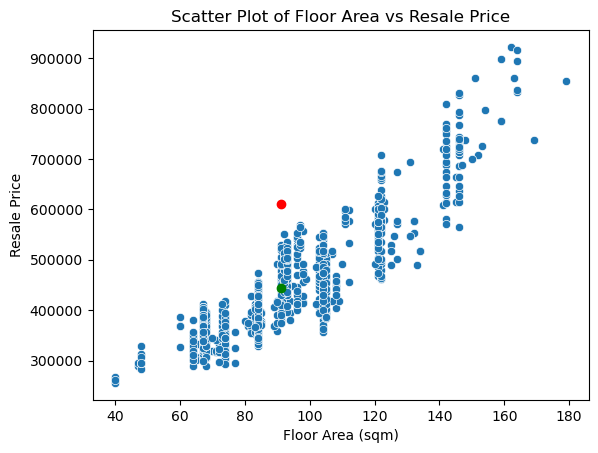

In [62]:
# Create scatter plot using Seaborn for visual aids in the powerpoint slides
sns.scatterplot(data=analysis, x='floor_area_sqm', y='resale_price')

# Set plot title and axis labels
plt.title('Scatter Plot of Floor Area vs Resale Price')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price')

#insert predicted point
plt.scatter(x=91, y=adjusted_value, color='red')
plt.scatter(x=91, y=answer, color='green')

# Display the plot
plt.show()

We can see from the feature with the most importance (floor area) that the resale prices of the actual transactions (blue) forms a clear trend. The predicted resale price (green) falls within the trend whereas the given resale price (red) appears to be an outlier.

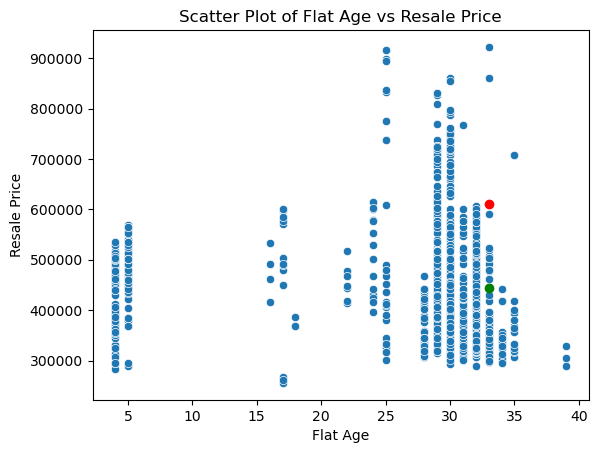

In [63]:
# Create scatter plot using Seaborn for visual aids to be used in the powerpoint slides
sns.scatterplot(data=analysis, x='flat_age', y='resale_price')

# Set plot title and axis labels
plt.title('Scatter Plot of Flat Age vs Resale Price')
plt.xlabel('Flat Age')
plt.ylabel('Resale Price')

#insert predicted point
plt.scatter(x=33, y=adjusted_value, color='red')
plt.scatter(x=33, y=answer, color='green')

# Display the plot
plt.show()

The second most important feature (flat age) also shows that the resale prices of the actual transactions (blue) forms a somewhat tight cluster at 33 years. The predicted resale price (green) falls within the trend whereas the given resale price (red) appears to be an outlier.

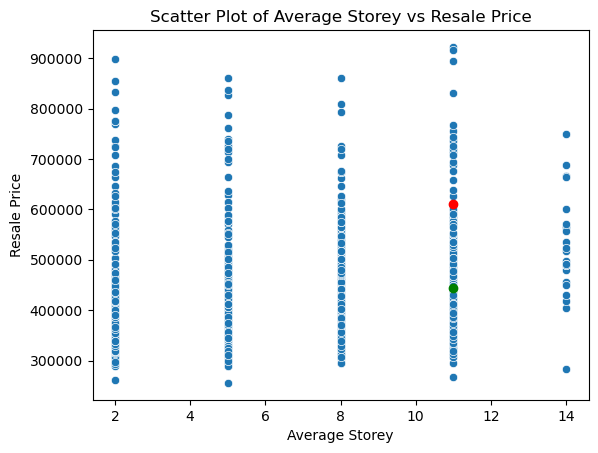

In [64]:
# Create scatter plot using Seaborn for visual aids in the powerpoint slides
sns.scatterplot(data=analysis, x='average_storey', y='resale_price')

# Set plot title and axis labels
plt.title('Scatter Plot of Average Storey vs Resale Price')
plt.xlabel('Average Storey')
plt.ylabel('Resale Price')

#insert predicted point
plt.scatter(x=11, y=adjusted_value, color='red')
plt.scatter(x=11, y=answer, color='green')

# Display the plot
plt.show()

From the scatter plot of the average story against the resale price, we can see that the given price (red) is a bit on the high side as compared to the predicted price (green). Although we can say that the buyer overpaid for the flat, we cannot say that the transaction is unreasonable from this metric.

From the various metrics for transaction held in Yishun during 2017, we can say that the transaction has a somewhat unreasonable price. However, the buyer may have placed more weightage on factors such as the storey level of the flat, and paid a premium for it.

# Section 2
## Question C

In this question we are working as a HDB data scientist.

Someone mistakenly deleted the column containing data on Flat Type in the database. While backups exist, these data are critical to HDB’s daily operations, and time would be needed to restore these data from the backup. Senior management would like you to create a model to predict flat type given a transaction’s other characteristics. Explain the reasons for choosing this model.

Firstly, the model needs to run without any data about the flat types of the transaction. This suggests an unsupervised machine learning model using either a K-means clustering or a K-medians clustering algorithm.

By inspection, many of the features would have no bearing on the flat types, such as storey range or year of transaction. Some would have little impact, such as executive flats being introduced only in 1984. However, other flat types are also constantly being built in 1984, so knowing that the lease commencement date is 1984 does not really help us in determining the type of flat being sold.

Floor area should be the most relevant feature to use in the clustering algorithm.

In [65]:
df.head()

,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,year,flat_age
0,1,01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,44.0,Improved,1979.0,232000.0,10,12,11,2017.0,38.0
1,2,01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,67.0,New Generation,1978.0,250000.0,1,3,2,2017.0,39.0
2,3,01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,67.0,New Generation,1980.0,262000.0,1,3,2,2017.0,37.0
3,4,01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,68.0,New Generation,1980.0,265000.0,4,6,5,2017.0,37.0
4,5,01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,67.0,New Generation,1980.0,265000.0,1,3,2,2017.0,37.0


In [68]:
# Create a dataframe for the K-means clustering
# Take into account inflation
kmeansdf = pd.merge(dfinflation, df, on='year', how='inner')

# Print the merged DataFrame
kmeansdf.head()

,year,CPI,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,flat_age
0,1990,62.102,1,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,9000.0,10,12,11,13.0
1,1990,62.102,2,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,6000.0,4,6,5,13.0
2,1990,62.102,3,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,8000.0,10,12,11,13.0
3,1990,62.102,4,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,6000.0,7,9,8,13.0
4,1990,62.102,5,01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,73.0,NEW GENERATION,1976.0,47200.0,4,6,5,14.0


In [69]:
# Cast the 'resale_price' and 'CPI' column to float type
kmeansdf['resale_price'] = kmeansdf['resale_price'].astype(float)
kmeansdf['CPI'] = kmeansdf['CPI'].astype(float)

# Standardising the resale prices to 2014 ddollars using the housing CPI for 2014
kmeansdf['resale_price'] = kmeansdf['resale_price'] / kmeansdf['CPI'] * 113.517

# Print the updated DataFrame
kmeansdf.head()


,year,CPI,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,flat_age
0,1990,62.102,1,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,16451.209301,10,12,11,13.0
1,1990,62.102,2,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,10967.472867,4,6,5,13.0
2,1990,62.102,3,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,14623.297156,10,12,11,13.0
3,1990,62.102,4,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,10967.472867,7,9,8,13.0
4,1990,62.102,5,01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,73.0,NEW GENERATION,1976.0,86277.453222,4,6,5,14.0


In [70]:
x=kmeansdf[['floor_area_sqm', 'resale_price', 'flat_age']]

# Specify the columns to cast as float
columns_to_cast = ['floor_area_sqm', 'resale_price', 'flat_age']

# Cast the specified columns to float
x[columns_to_cast] = x[columns_to_cast].astype(float)

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the DataFrame so that the clustering will not be skewed by large numbers
x_standardized = scaler.fit_transform(x)

# Create the k-means clustering model, using 7 clusters as there are 7 types of flats
k = 7  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=88)

# Fit the model to the data
kmeans.fit(x_standardized)

# Get the cluster labels
labels = kmeans.labels_

C:\Users\lizhi\AppData\Local\Temp\ipykernel_8464\4127709972.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[columns_to_cast] = x[columns_to_cast].astype(float)
c:\Users\lizhi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [71]:
# Corresponding the 'ground truth' flat types with the labels obtained by the K-means clustering
dfkmeans=pd.DataFrame({'Flat type':kmeansdf.flat_type, 'Labels':labels})
dfkmeans['Flat type'] = dfkmeans['Flat type'].replace('MULTI-GENERATION', 'MULTI GENERATION')
dfkmeans.head()

,Flat type,Labels
0,1 ROOM,0
1,1 ROOM,0
2,1 ROOM,0
3,1 ROOM,0
4,3 ROOM,0


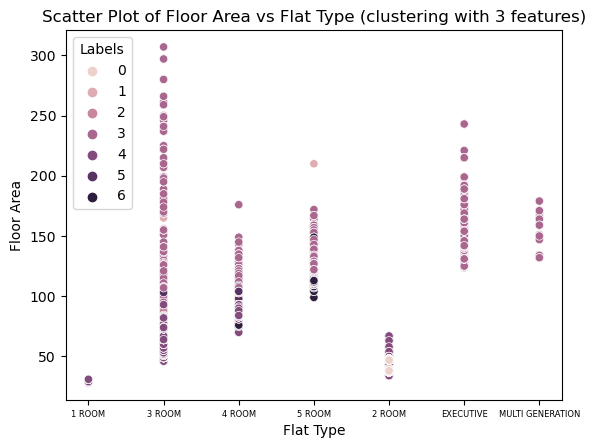

<Figure size 1000x400 with 0 Axes>

In [72]:
# Create scatter plot using Seaborn for visual aids to be used in the powerpoint slides
sns.scatterplot(x =dfkmeans['Flat type'],y=x['floor_area_sqm'],hue=dfkmeans['Labels'])

# Set plot title and axis labels
plt.title('Scatter Plot of Floor Area vs Flat Type (clustering with 3 features)')
plt.xlabel('Flat Type')
plt.ylabel('Floor Area')
plt.xticks(fontsize=6)
plt.figure(figsize=(10,4))

# Display the plot
plt.show()

C:\Users\lizhi\AppData\Local\Temp\ipykernel_8464\207623725.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[columns_to_cast] = x[columns_to_cast].astype(float)
c:\Users\lizhi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


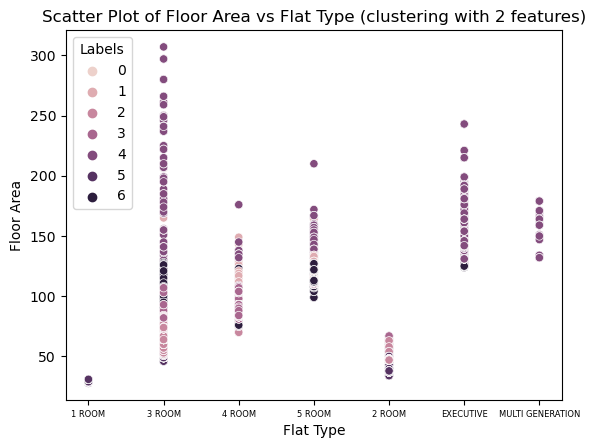

<Figure size 1000x400 with 0 Axes>

In [73]:
# Rrun the clustering with 2 features only to see if it makes a significant difference
x=kmeansdf[['floor_area_sqm', 'resale_price']]

# Specify the columns to cast as float
columns_to_cast = ['floor_area_sqm', 'resale_price']

# Cast the specified columns to float
x[columns_to_cast] = x[columns_to_cast].astype(float)

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the DataFrame
x_standardized = scaler.fit_transform(x)

# Create the k-means clustering model, using 7 clusters as there are 7 types of flats
k = 7  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=88)

# Fit the model to the data
kmeans.fit(x_standardized)

# Get the cluster labels
labels = kmeans.labels_

dfkmeans=pd.DataFrame({'Flat type':kmeansdf.flat_type, 'Labels':labels})
dfkmeans['Flat type'] = dfkmeans['Flat type'].replace('MULTI-GENERATION', 'MULTI GENERATION')
dfkmeans.head()

# Create scatter plot using Seaborn
sns.scatterplot(x =dfkmeans['Flat type'],y=x['floor_area_sqm'],hue=dfkmeans['Labels'])

# Set plot title and axis labels
plt.title('Scatter Plot of Floor Area vs Flat Type (clustering with 2 features)')
plt.xlabel('Flat Type')
plt.ylabel('Floor Area')
plt.xticks(fontsize=6)
plt.figure(figsize=(10,4))

# Display the plot
plt.show()

We can see that the clustering can give us an estimate of what flat types it will be. For example, flats that belong to cluster 0 tends to be 2 room, 3 room or 1 room flats. Flats that belong to cluster 6 and 5 tends to be executive, multi generation or 3 room flats.

However, from a business point of view, this is not good enough for the critical daily HDB operations and that a better option will be to just wait for the backups. From the scatter plot, the data seems anomalous, as 3 room flats seems to have larger floor areas then even 5 room or executive flats.

We shall do a quick check below to determine if this is an error.

In [74]:
df['floor_area_sqm'] = df['floor_area_sqm'].astype(float)
df.describe()

,_id,floor_area_sqm,lease_commence_date,resale_price,min_storey,max_storey,average_storey,year,flat_age
count,913667.000000,913667.000000,913667.000000,9.136670e+05,913667.000000,913667.000000,913667.000000,913667.000000,913667.000000
mean,137508.527613,95.698244,1988.128954,3.167469e+05,6.667617,8.682586,7.675102,2005.907045,17.778091
std,99726.049510,25.852053,10.510834,1.669953e+05,4.804473,4.804513,4.803720,9.135560,10.591536
min,1.000000,28.000000,1966.000000,5.000000e+03,1.000000,3.000000,2.000000,1990.000000,-2.000000
25%,47816.500000,73.000000,1981.000000,1.910000e+05,4.000000,6.000000,5.000000,1998.000000,9.000000
50%,122493.000000,93.000000,1986.000000,2.940000e+05,7.000000,9.000000,8.000000,2005.000000,16.000000
75%,214215.500000,113.000000,1996.000000,4.120000e+05,10.000000,12.000000,11.000000,2013.000000,25.000000
max,369651.000000,307.000000,2022.000000,1.500000e+06,49.000000,51.000000,50.000000,2023.000000,57.000000


In [75]:
check=df[df['floor_area_sqm']>=250]
check

,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,year,flat_age
170577,3114,03,KALLANG/WHAMPOA,3 ROOM,53,JLN MA'MOR,280.0,Terrace,1972.0,1060000.0,1,3,2,2015.0,43.0
203954,36491,12,KALLANG/WHAMPOA,3 ROOM,57,JLN MA'MOR,259.0,Terrace,1972.0,1150000.0,1,3,2,2016.0,44.0
229353,24737,04,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,266.0,Terrace,1972.0,1020000.0,1,3,2,2013.0,41.0
280893,24074,09,KALLANG/WHAMPOA,3 ROOM,57,JLN MA'MOR,259.0,Terrace,1972.0,515000.0,1,3,2,2000.0,28.0
280894,24075,09,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,266.0,Terrace,1972.0,550000.0,1,3,2,2000.0,28.0
302190,45371,04,KALLANG/WHAMPOA,3 ROOM,54,JLN MA'MOR,261.0,Terrace,1972.0,590000.0,1,3,2,2001.0,29.0
340735,83916,04,KALLANG/WHAMPOA,3 ROOM,58,JLN MA'MOR,297.0,Terrace,1972.0,565000.0,1,3,2,2002.0,30.0
413167,156348,08,KALLANG/WHAMPOA,3 ROOM,53,JLN MA'MOR,280.0,Terrace,1972.0,520000.0,1,3,2,2004.0,32.0
440698,183879,07,KALLANG/WHAMPOA,3 ROOM,43,JLN BAHAGIA,261.0,Terrace,1972.0,595000.0,1,3,2,2005.0,33.0
500560,243741,09,KALLANG/WHAMPOA,3 ROOM,42,JLN BAHAGIA,250.0,Terrace,1972.0,700000.0,1,3,2,2007.0,35.0


It seems that the extra large floor area is due to the 3 room flat belongs to the 'terrace' flat_model type. Potential refinements for the clustering model will be to take into account the 'flat_model'.